Подключение библиотек:

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Загрузка исходной таблицы:

In [2]:
from google.colab import files
uploaded = files.upload()

Saving winequality-red.csv to winequality-red (4).csv


In [3]:
dataframe = pd.read_csv('winequality-red (4).csv', sep=';')
dataframe

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [4]:
dataframe.shape
print('Размерность базы данных: ', dataframe.shape)

Размерность базы данных:  (1599, 12)


Поделим исходную базу данных на 2 части для машинного обучения:
1.   Обучение нейросети (70% данных)
2.   Валидация данных




In [7]:
val_dataframe = dataframe.sample(frac=0.3, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Используется %d для тестирования и %d для валидации"
    % (len(train_dataframe), len(val_dataframe))
)

Используется 1119 для тестирования и 480 для валидации


/Для дальнейших операций необходимо преобразовать dataframe в dataset/

In [8]:
def dataframe_to_dataset(dataframe):
  dataframe = dataframe.copy()
  labels = dataframe.pop("quality")
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  ds = ds.shuffle(buffer_size=len(dataframe))
  return ds

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)


В качестве выходного параметра рассмотрим критерий "Качество (quality)"

In [9]:
for x,y in train_ds.take(1):
    print("Input:",x)
    print("quality:",y)


Input: {'fixed acidity': <tf.Tensor: shape=(), dtype=float64, numpy=6.2>, 'volatile acidity': <tf.Tensor: shape=(), dtype=float64, numpy=0.46>, 'citric acid': <tf.Tensor: shape=(), dtype=float64, numpy=0.29>, 'residual sugar': <tf.Tensor: shape=(), dtype=float64, numpy=2.1>, 'chlorides': <tf.Tensor: shape=(), dtype=float64, numpy=0.074>, 'free sulfur dioxide': <tf.Tensor: shape=(), dtype=float64, numpy=32.0>, 'total sulfur dioxide': <tf.Tensor: shape=(), dtype=float64, numpy=98.0>, 'density': <tf.Tensor: shape=(), dtype=float64, numpy=0.99578>, 'pH': <tf.Tensor: shape=(), dtype=float64, numpy=3.33>, 'sulphates': <tf.Tensor: shape=(), dtype=float64, numpy=0.62>, 'alcohol': <tf.Tensor: shape=(), dtype=float64, numpy=9.8>}
quality: tf.Tensor(5, shape=(), dtype=int64)


In [10]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

Препроцессинг данных:

In [11]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup

def encode_numerical_feature(feature,name,dataset):
  normalizer = Normalization()

  feature_ds = dataset.map(lambda x,y: x[name])
  feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

  normalizer.adapt(feature_ds)

  encoded_feature = normalizer(feature)
  return encoded_feature

Построение модели:

In [12]:
fixed_acidity = keras.Input(shape=(1,), name="fixed acidity")
volatile_acidity = keras.Input(shape=(1,), name="volatile acidity")
citric_acid = keras.Input(shape=(1,), name="citric acid")
residual_sugar = keras.Input(shape=(1,), name="residual sugar")
chlorides = keras.Input(shape=(1,), name="chlorides")
free_sulfur_dioxide = keras.Input(shape=(1,), name="free sulfur dioxide")
total_sulfur_dioxide = keras.Input(shape=(1,), name="total sulfur dioxide")
density = keras.Input(shape=(1,), name="density")
pH = keras.Input(shape=(1,), name="pH")
sulphates = keras.Input(shape=(1,), name="sulphates")
alcohol = keras.Input(shape=(1,), name="alcohol")
							
all_inputs = [
    fixed_acidity,
    citric_acid,
    residual_sugar,
    chlorides,
    free_sulfur_dioxide,
    total_sulfur_dioxide,
    density,
    pH,
    sulphates,
    alcohol,
]

fixed_acidity_encoded = encode_numerical_feature(fixed_acidity, "fixed acidity", train_ds)
volatile_acidity_encoded = encode_numerical_feature(volatile_acidity, "volatile acidity", train_ds)
citric_acid_encoded = encode_numerical_feature(citric_acid, "citric acid", train_ds)
residual_sugar_encoded = encode_numerical_feature(residual_sugar, "residual sugar", train_ds)
chlorides_encoded = encode_numerical_feature(chlorides, "chlorides", train_ds)
free_sulfur_dioxide_encoded = encode_numerical_feature(free_sulfur_dioxide, "free sulfur dioxide", train_ds)
total_sulfur_dioxide_encoded = encode_numerical_feature(total_sulfur_dioxide, "total sulfur dioxide", train_ds)
density = encode_numerical_feature(density, "density", train_ds)
pH = encode_numerical_feature(pH, "pH", train_ds)
sulphates = encode_numerical_feature(sulphates, "sulphates", train_ds)
alcohol = encode_numerical_feature(alcohol, "alcohol", train_ds)

all_features = layers.concatenate(
    [
    fixed_acidity,
    citric_acid,
    residual_sugar,
    chlorides,
    free_sulfur_dioxide,
    total_sulfur_dioxide,
    density,
    pH,
    sulphates,
    alcohol,
    ]
)

x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["mae"])


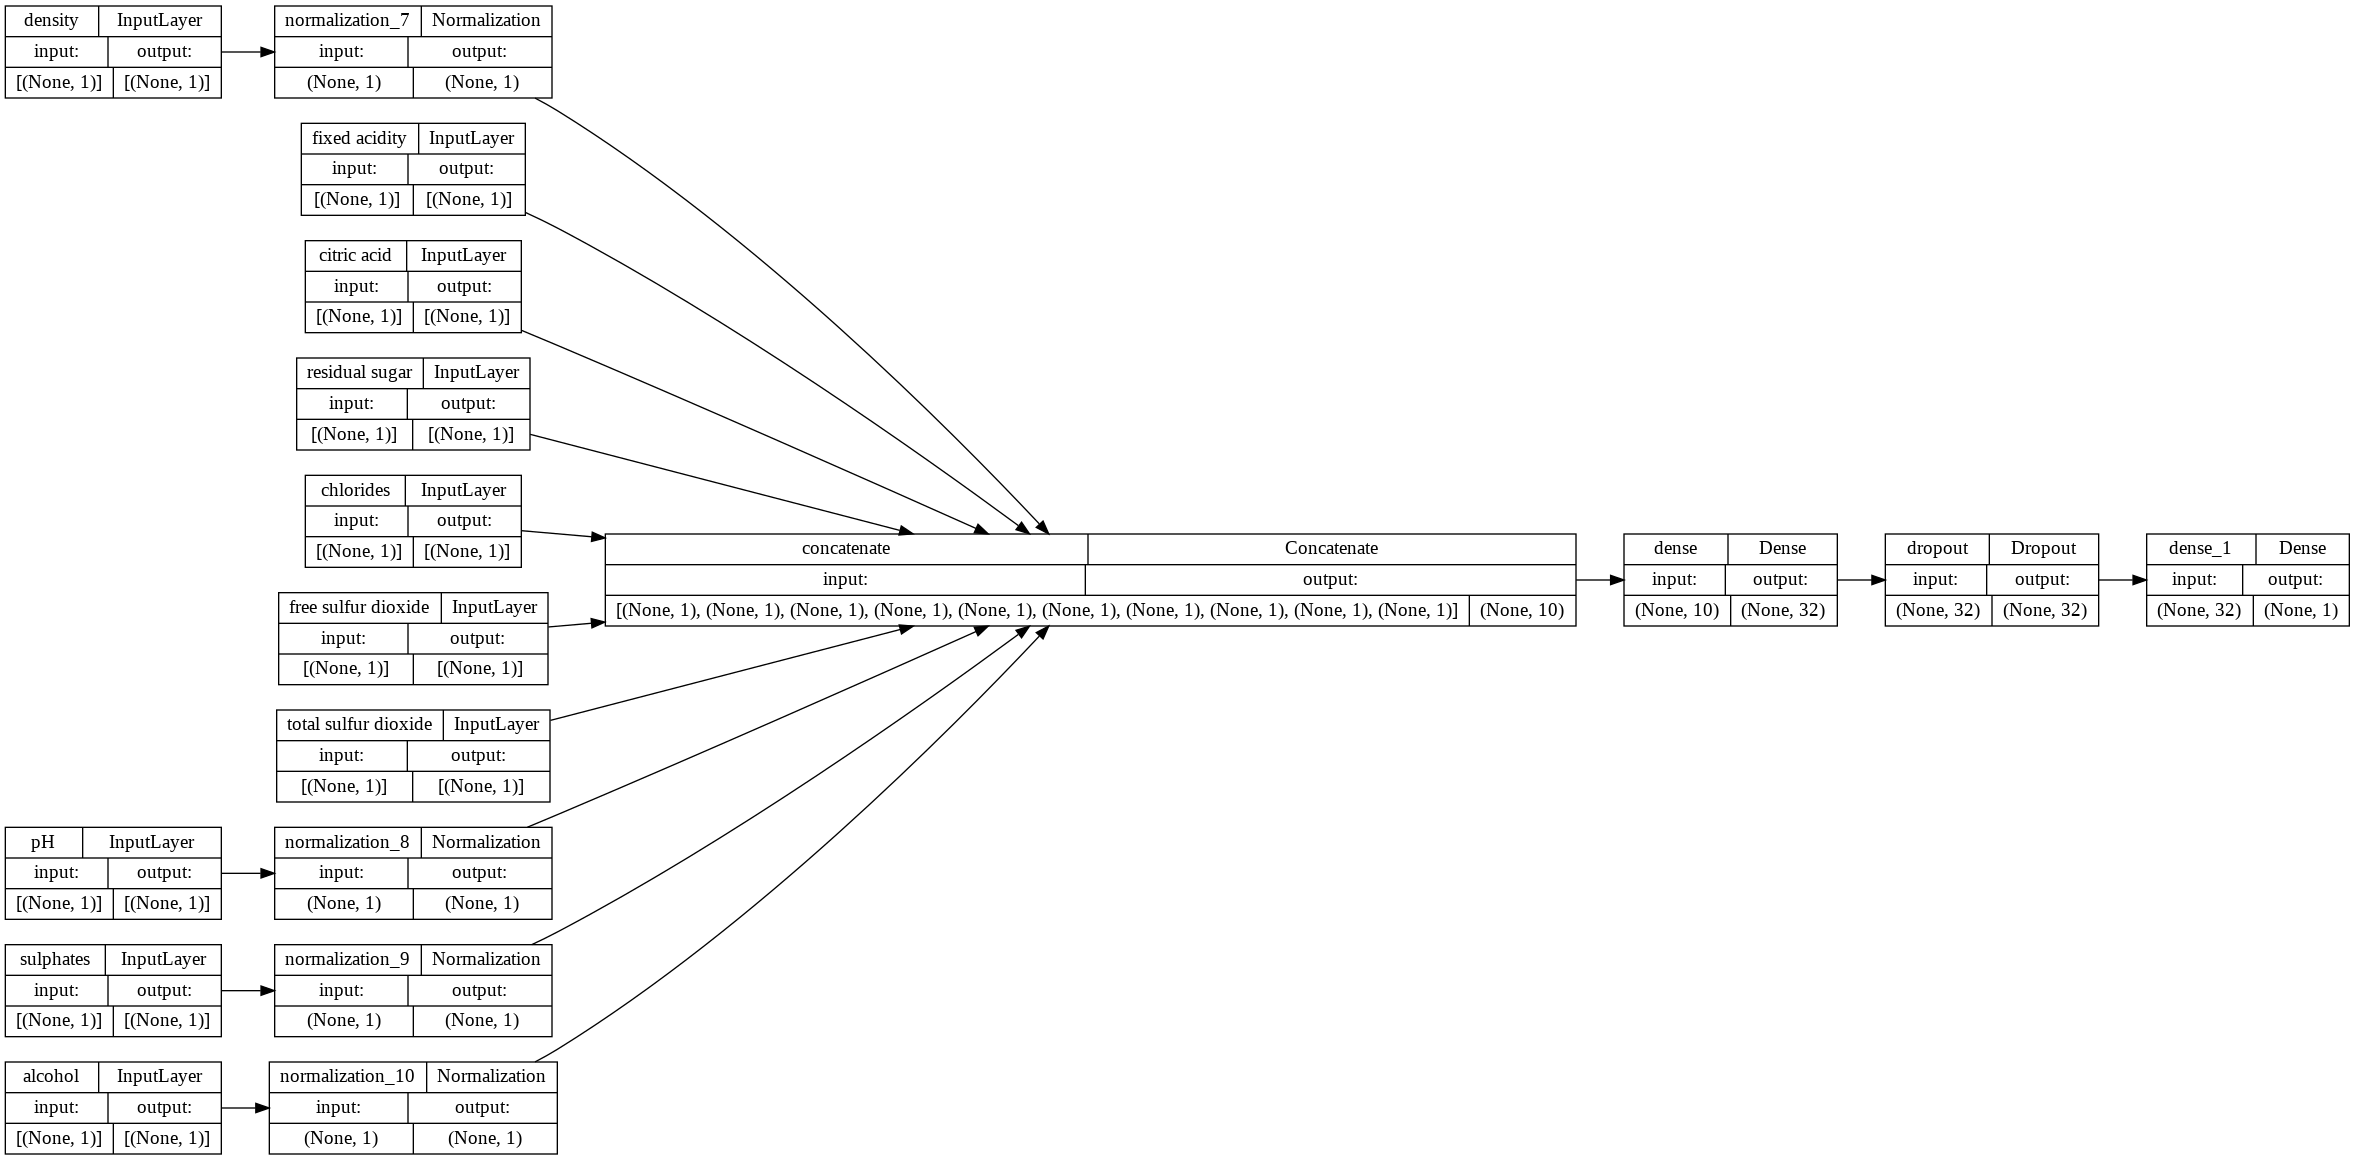

In [13]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Обучение модели:

In [14]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['volatile acidity'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


35/35 [==============================] - 1s 7ms/step - loss: -5.5872 - mae: 5.0896 - val_loss: -37.0170 - val_mae: 4.6601
Epoch 2/50
35/35 [==============================] - 0s 3ms/step - loss: -70.8977 - mae: 4.7982 - val_loss: -94.7291 - val_mae: 4.6339
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - loss: -138.0437 - mae: 4.6740 - val_loss: -160.4820 - val_mae: 4.6333
Epoch 4/50
35/35 [==============================] - 0s 3ms/step - loss: -207.1506 - mae: 4.6479 - val_loss: -235.7095 - val_mae: 4.6333
Epoch 5/50
35/35 [==============================] - 0s 2ms/step - loss: -293.8726 - mae: 4.6425 - val_loss: -323.4512 - val_mae: 4.6333
Epoch 6/50
35/35 [==============================] - 0s 3ms/step - loss: -390.9004 - mae: 4.6395 - val_loss: -426.4869 - val_mae: 4.6333
Epoch 7/50
35/35 [==============================] - 0s 3ms/step - loss: -512.5305 - mae: 4.6376 - val_loss: -547.4472 - val_mae: 4.6333
Epoch 8/50
35/35 [==============================] - 0s 3ms/step 

По итогу 50 эпох, имеем среднюю квадратичную ошибку 4.63